<a href="https://colab.research.google.com/github/niigoatnightcord/595project/blob/main/Modified_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

#only load train_data set
train_data = h5py.File('train_catvnoncat.h5', 'r')

X_train = np.array(train_data['train_set_x'][:])  #img
Y_train = np.array(train_data['train_set_y'][:])  #label

#modified train set:the first 167 img
X_train_modified = X_train[:167]
Y_train_modified = Y_train[:167]

#modified test set: remaining img
X_test_modified = X_train[167:]
Y_test_modified = Y_train[167:]

# normalize pixel value
X_train_modified = X_train_modified / 255.0
X_test_modified = X_test_modified / 255.0

# convert array to tensor (n, h, w, c) -> (n, c, h, w)
X_train_tensor = torch.tensor(X_train_modified, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test_modified, dtype=torch.float32).permute(0, 3, 1, 2)

Y_train_tensor = torch.tensor(Y_train_modified, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test_modified, dtype=torch.long)



In [3]:
# define custom dataset class
class CatVsNonCatDataset(Dataset):
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.Y_data[idx]

# define DataLoader
train_dataset = CatVsNonCatDataset(X_train_tensor, Y_train_tensor)
test_dataset = CatVsNonCatDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

       #initialize variable for the fully connected layer input size
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.pool,
            self.conv2,
            nn.ReLU(),
            self.pool
        )
        self._get_conv_output_size((3, 64, 64))  # img size (3, 64, 64)

        # define fully connected layer
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 2)  #second fully connected layer (output layer for binary classification)

    def _get_conv_output_size(self, shape):
        """计算经过卷积层和池化层后的输出大小"""
        o = self.convs(torch.zeros(1, *shape))  # dummy input
        self._to_linear = int(np.prod(o.size()))  #calculate the flattened size after passing through the conv layers
        return self._to_linear

    def forward(self, x):
        x = self.convs(x)#pass input through the convolution layers
        x = x.reshape(x.size(0), -1)#flatten the output
        x = torch.relu(self.fc1(x))#ReLU activation
        x = self.fc2(x)#pass through the second fully connected layer (no activation, since this is a classification output)
        return x



Epoch [1/10], Loss: 0.6958420475323995
Epoch [2/10], Loss: 0.6658352613449097
Epoch [3/10], Loss: 0.6582154631614685
Epoch [4/10], Loss: 0.6443645556767782
Epoch [5/10], Loss: 0.6389461755752563
Epoch [6/10], Loss: 0.6349608103434244
Epoch [7/10], Loss: 0.6304967403411865
Epoch [8/10], Loss: 0.6144993901252747
Epoch [9/10], Loss: 0.6198381185531616
Epoch [10/10], Loss: 0.5963788429896036
Test Accuracy: 71.42857142857143%


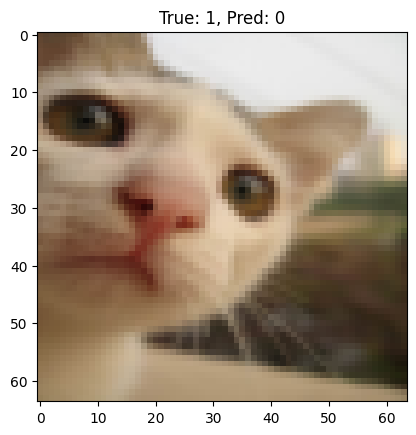

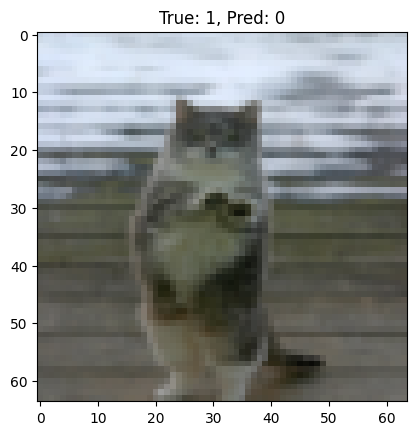

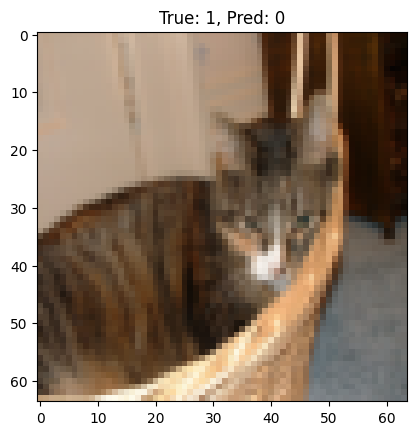

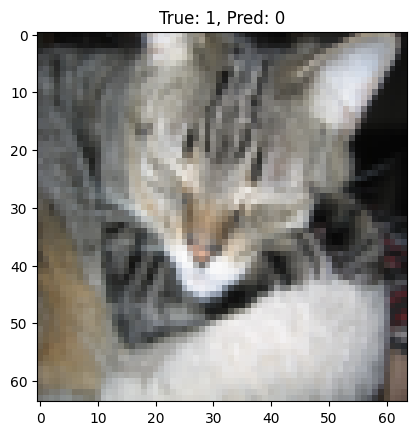

In [4]:
#train the model
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()#use crossentropy as loss function

# use SGD as optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
#loop over each epoch
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

#evaluate model over test set
model.eval()
correct = 0
total = 0
misclassified_indices = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #track misclassified img
        misclassified_indices.extend((predicted != labels).nonzero(as_tuple=True)[0].tolist())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

#display misclassified img
misclassified_images = X_test_tensor[misclassified_indices[:4]]
misclassified_labels = Y_test_tensor[misclassified_indices[:4]]
misclassified_preds = torch.argmax(model(misclassified_images), dim=1)

for i in range(4):
    plt.imshow(misclassified_images[i].permute(1, 2, 0).numpy())
    plt.title(f"True: {misclassified_labels[i].item()}, Pred: {misclassified_preds[i].item()}")
    plt.show()
